## Create artificial data function

In [6]:
using DataFrames
using Dates
using Random
using TSML
using Plots
using TSML: transform!, transform, fit!, fit

ENV["COLUMNS"]=1000 # for dataframe column size

function generateXY()
    Random.seed!(123)
    gdate = DateTime(2014,1,1):Dates.Minute(15):DateTime(2014,1,5)
    gval = Array{Union{Missing,Float64}}(rand(length(gdate)))
    gmissing = floor(0.30*length(gdate)) |> Integer
    gndxmissing = Random.shuffle(1:length(gdate))[1:gmissing]
    X = DataFrame(Date=gdate,Value=gval)
    X.Value[gndxmissing] .= missing
    Y = rand(length(gdate))
    (X,Y)
end;

## Generate artificial data with missing

In [7]:
(df,outY)=generateXY()
first(df,10)

Row,Date,Value
,DateTime,Float64?
1,2014-01-01T00:00:00,0.9063
2,2014-01-01T00:15:00,0.443494
3,2014-01-01T00:30:00,0.745673
4,2014-01-01T00:45:00,0.512083
5,2014-01-01T01:00:00,missing
6,2014-01-01T01:15:00,0.334152
7,2014-01-01T01:30:00,missing
8,2014-01-01T01:45:00,missing
9,2014-01-01T02:00:00,0.0991336


## User Pipeline and Plotter to plot artificial data

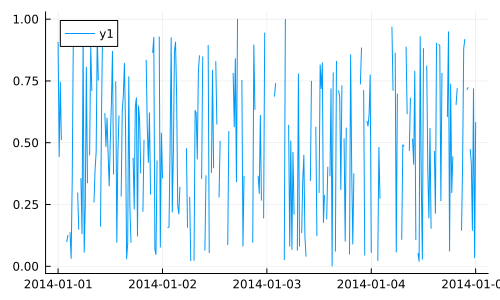

In [8]:
pltr=Plotter(Dict(:interactive => false))

mypipeline = pltr

fit!(mypipeline, df)
transform!(mypipeline, df);

## Get statistics including blocks of missing data

In [9]:
statfier = Statifier(Dict(:processmissing=>true))

mypipeline = statfier

fit!(mypipeline, df)
res = transform!(mypipeline, df)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-01-05T00:00:00,0.249351,270,0.999721,0.000981938,0.47879,0.481656,0.0787459,0.157719,0.230357,0.728315,0.778832,0.883753,-1.22101,0.0106693,0.602218,67.6642,0.25577,0.275333,1.0,1.30682,1.0,1.25,1.0,4.0


## Use Pipeline: aggregate, impute, and plot 

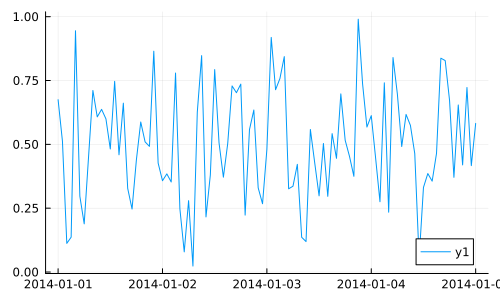

In [93]:
interval = Dict(:dateinterval=>Dates.Hour(1))
valgator = DateValgator(interval)
valnner = DateValLinearImputer(interval)

mypipeline = valgator |> valnner |> pltr

fit_transform!(mypipeline, df);

## Try real data

In [94]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvreader = CSVDateValReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))

outputname = joinpath(dirname(pathof(TSML)),"/tmp/testdata_output.csv")
csvwriter = CSVDateValWriter(Dict(:filename=>outputname))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Plot real data with missing values

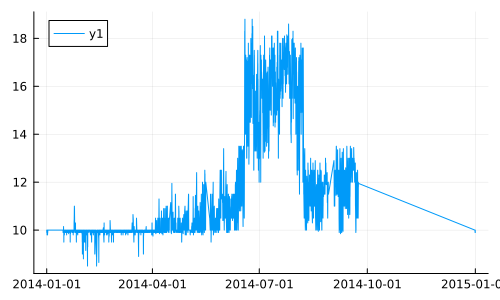

In [98]:
mpipeline1 = csvreader |> valgator |> pltr

fit!(mpipeline1)
transform!(mpipeline1);

## Get statistics including blocks of missing data

In [99]:
mpipeline1 = csvreader |> valgator |> stfier 

fit_transform!(mpipeline1)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-12-31T15:00:00,0.998859,3830,18.8,8.5,10.35,11.557,9.9,10.0,10.0,12.3,13.0,16.0,0.730635,1.41283,0.200055,-1.09145e5,4.39315,1.04644,4931.0,4931.0,4931.0,4931.0,4931.0,4931.0


## Try imputing and get statistics

In [100]:
mpipeline2 = csvreader |> valgator |> valnner |> stfier

fit_transform!(mpipeline2)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-12-31T15:00:00,0.998859,8761,18.8,8.5,9.9,10.6244,9.9,9.9,9.9,10.0,10.5,12.5,6.67036,2.7373,0.163356,-2.21059e5,4.50868,1.05318,NaN,NaN,NaN,NaN,NaN,NaN


## Plot imputted data

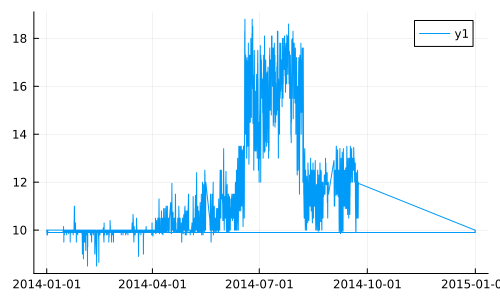

In [101]:
mpipeline2 = csvreader|> valgator |> valnner |> pltr

fit_transform!(mpipeline2);

### Monotonicer

In [102]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")

regularfilecsv = CSVDateValReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = CSVDateValReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = CSVDateValReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1),:strict=>false))
stfier = Statifier(Dict(:processmissing=>true))
mono = Monotonicer(Dict())
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Plot of monotonic data

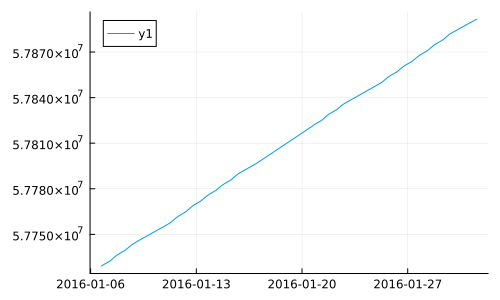

In [103]:
monopipeline = monofilecsv|> valgator |> pltr

fit_transform!(monopipeline);

## Plot after normalization of monotonic data

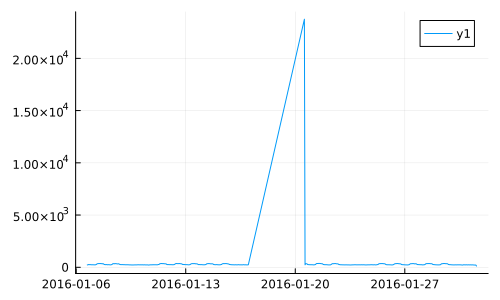

In [104]:
monopipeline = monofilecsv |> valgator  |> mono  |> pltr
fit_transform!(monopipeline);

## Plot with Monotonicer and Outliernicer

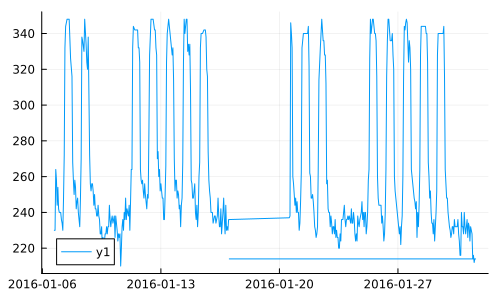

In [107]:
monopipeline = monofilecsv |> valgator |> valnner |> mono |> outliernicer |> pltr

fit_transform!(monopipeline);

## Plot of daily monotonic

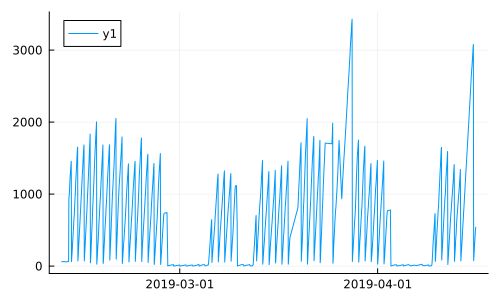

In [108]:
dailymonopipeline = dailymonofilecsv |> valgator |> pltr

fit_transform!(dailymonopipeline);

## Plot of daily monotonic data with Monotonicer

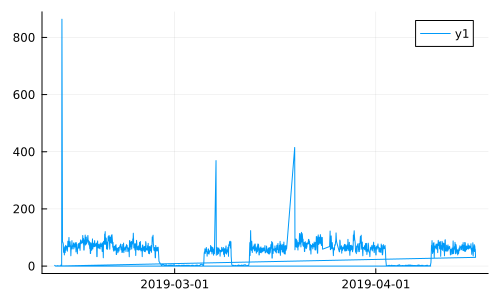

In [109]:
dailymonopipeline = dailymonofilecsv |> valgator |> valnner |> mono |> pltr 
 

fit!(dailymonopipeline)
transform!(dailymonopipeline);

## Plot of daily monotonic with Monotonicer and Outliernicer

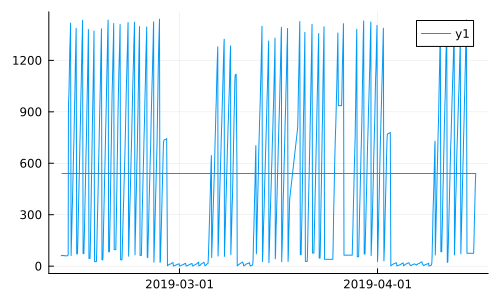

In [112]:
dailymonopipeline = dailymonofilecsv |> valgator |> valnner |> outliernicer |> pltr 

fit!(dailymonopipeline)
transform!(dailymonopipeline);

## Plot regular TS after monotonic normalization

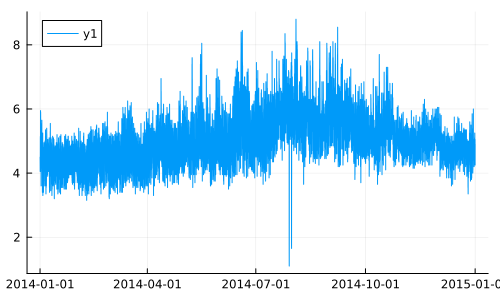

In [113]:
regpipeline = regularfilecsv |> valgator  |> valnner |> mono |> pltr

fit!(regpipeline)
transform!(regpipeline);

## Plot of regular TS with outlier normalization

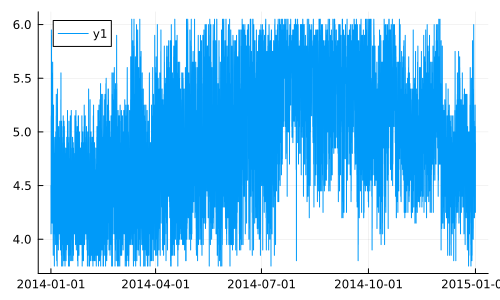

In [114]:
regpipeline = regularfilecsv |> valgator |> valnner |> mono |> outliernicer |> pltr
fit!(regpipeline)
transform!(regpipeline);

## TS Discovery by automatic data type classification

In [115]:
using TSML: TSClassifier
Random.seed!(12)

trdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/training")
tstdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/testing")
modeldirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/model")

tscl = TSClassifier(Dict(:trdirectory=>trdirname,
           :tstdirectory=>tstdirname,
           :modeldirectory=>modeldirname,
           :feature_range => 6:20,
           :num_trees=>10)
)

fit!(tscl)
dfresults = transform!(tscl)

getting stats of AirOffTemp1.csv
getting stats of AirOffTemp2.csv
getting stats of AirOffTemp3.csv
getting stats of Energy1.csv
getting stats of Energy10.csv
getting stats of Energy2.csv
getting stats of Energy3.csv
getting stats of Energy4.csv
getting stats of Energy6.csv
getting stats of Energy7.csv
getting stats of Energy8.csv
getting stats of Energy9.csv
getting stats of Pressure1.csv
getting stats of Pressure3.csv
getting stats of Pressure4.csv
getting stats of Pressure6.csv
getting stats of RetTemp11.csv
skipping RetTemp21.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
skipping RetTemp41.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
getting stats of RetTemp51.csv
getting stats of AirOffTemp4.csv
getting stats of AirOffTemp5.csv
getting stats of Energy5.csv
getting stats of Pressure5.csv
skipping RetTemp31.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
loading model from file: /Users/ppalmes/phome/julia/TS

Row,fname,predtype
,String,SubStrin…
1,AirOffTemp4.csv,AirOffTemp
2,AirOffTemp5.csv,Energy
3,Energy5.csv,Energy
4,Pressure5.csv,Pressure


In [116]:
apredict = dfresults.predtype
fnames = dfresults.fname
myregex = r"(?<dtype>[A-Z _ - a-z]+)(?<number>\d*).(?<ext>\w+)"
mtypes=map(fnames) do fname
  mymatch=match(myregex,fname)
  mymatch[:dtype]
end

sum(mtypes .== apredict)/length(mtypes) * 100

75.0